# Objective
------------
Our goal is to build a system that recommends highly relevant movies to users.
In order to achieve this, our system must accurately predict the rating that a user will give to an unseen item 
as well as display items of high interest to the user.
Therefore, we will be monitoring two key metrics throughout our analyses: root-mean-squared error (RMSE) and precision.
RMSE allows us to measure the accuracy of each prediction and precision allows us to measure 
the relevance of our recommendations as a whole.
We will be developing a two-model mixed hybrid system, where one model will have a content-based approach and the other
model will have an approximate nearest neighbors approach.
A mixed hybrid system is a system where recommendations from both models are served simultaneously to a user.
Our benchmarks for each model will be the baseline algorithms found in the Python Surprise package.
We will also be monitoring recall as a metric for serendipity in the content-based approach.

# Dataset and Sampling
--------------------------

MovieLens 20M Dataset: 20,000,000 ratings from 138,000 users on 27000 movies. <br>
https://grouplens.org/datasets/movielens/20m/
    
A link to all of our data, source code, and results:
https://drive.google.com/drive/folders/1dQsyB3lVi2yp9pMlef4qzG4H41EtaVGb?usp=sharing

We split the 20M dataset into five separate datasets with 4M ratings each ( split_1.csv to split_5.csv).
Split_5.csv is held out as the final testset and the remaining 4 splits are used for training and tuning


# Models & Methodology
----------------------
### Content-based Approach:
The content-based approach attempts to dissect each item into a list of features that best describes that given item. 
Then, we try to describe each user using these same features by analyzing the previous rating history of that user. 
For example, if a given user consistently gives romance films high ratings, then we can deduce that the user is 
a fan of romance films and the user's model will reflect that.
Next, we compute a predicted rating for a given user and a given item by examining how closely their features
are aligned. That is, the fan of romance of films and  romance films that the user has not already consumed will 
likely have a high similarity value.
We will compute a predicted rating for every user and item pair that the user has not already consumed.
Finally, we can sort these predicted ratings from greatest to least and recommend the top k items to a user. 

Our process and methodology in constructing the content-based model is detailed below: <br>

**1) Determine desired features for user/item vectors. <br>**
During this initial step, we wanted to include features that were important descriptors of movies, but can also be used to
describe the users.
We ultimately decided that the primary features to include were: genre, cast, director, and IMDB rating.
Since we could not include every actor/actress and director for every film, we filtered the cast and director features
down to approximately 800 people for these two categories.
This was done by selecting the highest grossing actors/actresses and directors. 
The total (genre + cast + director + IMDB rating) feature space has 1,757 dimensions.

**2) Extract features for each movie in dataset from IMDB API and build item profiles. <br>**
We utilized the IMDbPY API to extract genre, cast, and director data for all 27,000 movies.
We then used the IMDB data to build the item feature vector for each movie.
For example, if a given movie was designated as an action film on IMDB, then a "1" was placed in the matrix entry 
corresponding to the feature "Action". For every category that the movie does not belong to, a "0" was placed in the
matrix entry. This process was done for every feature and every movie in our dataset.

**3) Build user profiles for each user in the dataset. <br>**
We construct the user profile by weighted average over the updated item profiles that the user has rated. Updated item profiles are the ones obtained by giving different weights to different features. (Ex: weight_of_genre = 1, weight_of_cast = 5, weight_of_director =5, weight_of_imdbRating = 1)

The weights used in constructing user profiles are (user_rating - mean_user_rating)/(numnber of movies the user rated)

Ex: Suppose user 1 (U1) rated movies M1, M2, M3 as 1,5,3. 

Let the feature space be {genre, cast, director, imdb rating}. Let the feature vectors of M1, M2, M3 be [1,1,0,0.5], [0,1,1,1], [1,1,1,1]. 

mean_user_rating = (1+5+3)/3 = 3

number of movies user rated = 3

suppose we give weights of features as w_genre = 1, w_actor = 5, w_director = 5, w_imdbRating =1, then the updated item profiles of M!, M2, M3 are [1,5,0,0.5], [0,5,5,1], [1,5,5,1] respectively.

User profile of user U1 is computed as (1-3)/3 x [1,5,0,0.5] + (5-3)/3 x [0,5,5,1] + (3-3)/3 x [1,5,5,1] which is 
[-0.667, 0, 3.333, 0.333]


**4) Combine item profiles and user profiles into the same feature space to then compute similarity metric. <br>**
After creating all item profiles and user profiles, we then compute the similarity metric (i.e. cosine similarity) between
every user vector and every item vector that the user has not already interacted with. This similarity metric will then 
be rescaled to a value between 0.5 and 5.0, which will then represent the models's predicted rating for a user toward
a specific item.

**5) Recommend the top k (i.e. 10) items to user. <br>**
Sort predicted ratings from highest to lowest and recommend the top k items to the user. If the user consumes an item
and provides feedback, then the process restarts from step 3.

Note: This practice of predicting every missing element in the user-item matrix and recommending the top k
items is often too computationally expensive. This matrix is very large and requires constant updating whenever 
there are any changes to the user profiles. To address this issue, we would suggest only computing/recomputing the 
missing matrix values periodically (i.e. once a day, week, month) or using an approximate nearest neighbors algorithm as described later.

### Content-based Results:

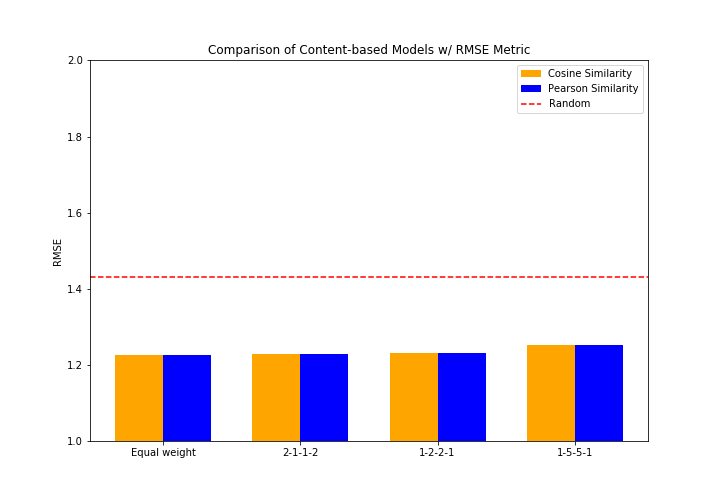

In [1]:
from IPython.display import Image
Image(filename='RMSE.png')

The above graph shows the plot of RMSE for different combinations of weights for each feature category (genre, cast, director, imdb rating). For example, 2-1-1-2 refers to the content-based model with a weights of 2, 1, 1, 2 for genre, cast, director, and IMDB rating, respectively. The red line represents the Normal Predictor benchmark RMSE. The Normal Predictor algorithm assign a random rating according to the distribution of the training set, which is assumed to be normal (Python Surprise package). We can observe from the above graph that all variations of our content-based model outperform the Normal Predictor benchmark.

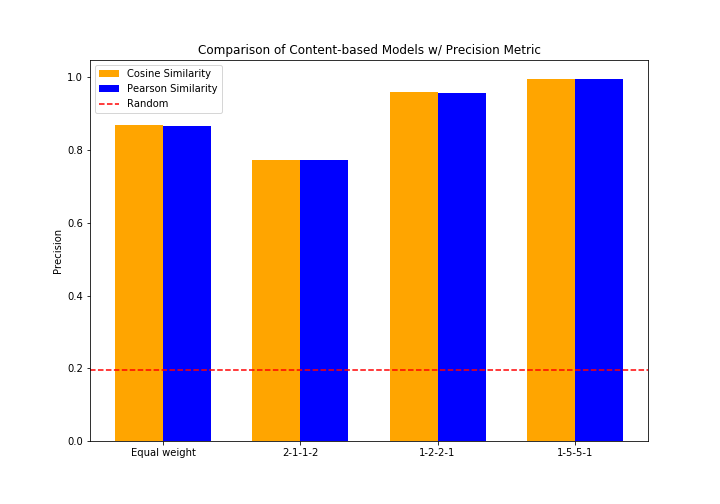

In [2]:
from IPython.display import Image
Image(filename='precision.png')

Precision is a measure of how relevant recommendations are to a given user. In our specific case. we measure precision by comparing the actual ratings against the predicted ratings for the 10 movies that we recommend. If we recommend a movie that has an actual rating of 3.5 or above, then we consider the movie to be relevant. Otherwise, it is irrelevant. As evinced by the graph, all variations of our content-based model outperform the Normal Predictor benchmark in terms of precision by a large margin. 

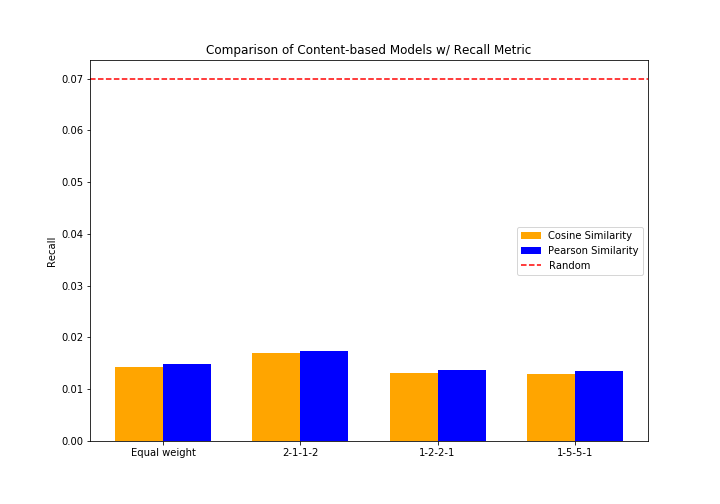

In [3]:
from IPython.display import Image
Image(filename='recall.png')

Recall of all content-based variations is around 0.01, whereas the recall for Normal Predictor Baseline Algorithm is 0.07. Recall is very low because we are only recommending a sliver of possible candidate items (10 items out tens of thousand of possible items). Furthermore, recall naturally tends to be low for content-based approaches because content-based recommenders usually provide the most probable recommendations to a user.


<table class="table table-bordered table-hover table-condensed">
<thead><tr><th title="Field #1">Metric</th>
<th title="Field #2">Collaborative Filtering Model (project_part1)*</th>
<th title="Field #3">Content Based Model (1-5-5-1)</th>
</tr></thead>
<tbody><tr>
<td align="right">RMSE</td>
<td>0.913</td>
<td>1.226</td>
</tr>
<tr>
<td align="right">Precision</td>
<td>0.72</td>
<td>0.997</td>
</tr>
<tr>
</tbody></table>




*The best collaborative filtering model from the first part of our project was the item-based KNN Baseline algorithm using pearson correlation as the similarity metric. The best content based model for our 20 million ratings dataset is the one with the follwoing weights (w_genre = 1, w_cast = 5, w_director = 5, w_imdbRating = 1) and pearson correlation similarity. 
We did not compare recall values of content-based models as they tend to have poor recalls.

In [ ]:
Although the collaborative filtering models from 

### Baseline Approach and Results: <br>
We implemented the baseline approach from the python surprise library on our dataset (refer to http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly). <br>
This is our baseline model where the predicted rating $\hat{r}_{ui} = b_{ui} = \mu + b_u + b_i$.<br>

In one of the KNN algorithms,i.e., KNNBaseline, we can take into account the baseline ratings. We therefore did the grid search on baselines to find the optimal combination of hyper parameters giving the best performance and used the tuning datasets to check the accuracy of our tuned model. Using the ALS algorithms to learn the parameters we obtain the following results.

ALS (RMSE: 0.8496 and MAE: 0.6521) 
n_epochs: 100 
reg_i: 5
reg_u: 5


### LSH Cosine (sim hash): <br>

Here we implement the KNN based models, but using only the approximate nearest neighbors. We used two different variations of KNN. They are KNN Basic, KNN Baseline.  
Notation: <br>

k: The maximum number of neighbors to take into account <br>
$ N_i^k(u) $ : The set consisting of at most k neighbors of user u who have rated item i <br>
$ N_u^k(i) $ : The set consisting of at most k neighbors of item i rated by user u <br>
$ sim(u,v) $ : Similarity of user u to user v <br>
$ sim(i,j) $ : Similarity of item i to item j <br>

We used the following similarity metrics: Cosine Similarity, Pearson Correlation with Baseline Similarity.

#### Cosine similarity: <br>
$
\text{cosine_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r_{ui} \cdot r_{vi}}
{\sqrt{\sum\limits_{i \in I_{uv}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r_{vi}^2}
}
$

#### Pearson Baseline similarity: <br>
$
\text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} -
b_{vi})} {\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2}
\cdot \sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}}
$

Accuracy Metric used: RMSE (Root Mean Squared Error) , MAE (Mean Absolute Error)

### i) KNN Basic: <br>
$\hat{r}_{ui}$ : Predicted rating of user u for item i <br>
User Based: <br>
$ \hat{r}_{ui} = \frac{
\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}
{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} $ 

### ii) KNN Baseline:

Here we take into account the baseline ratings $b_{ui}$. <br> 

User Based:

$ \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} $

## Sim-Hash (Cosine similarity):

We refer to the following paper for cosine similarity hashing (http://www.cs.princeton.edu/courses/archive/spr04/cos598B/bib/CharikarEstim.pdf) and implimentation from the github repository (https://github.com/marufaytekin/lsh-spark).<br>

We implemented the Sim Hash for the users using pyspark as demonstrated below. (refer to complete_run.py)
1) create a random vector of size number of movies having values -1,1 (using a normal distribution) <br>
2) calculate dot product of the random vector and the item rating vector of the user, if the dot product is >0 output 1 else output 0 <br>
3) repeat steps 1 and 2 for b bands and r rows <br>

If we see the distribution of similarity of a sample user with all other users and number of movies in common with other users, we see an expected behaviour. We see more users with small number of common movies and the similarities being high because of the small number of common movies. Hence we use a high threshold range of (0.8,0.9) for identifying similar users.
(refer to user_data_plot.ipynb)

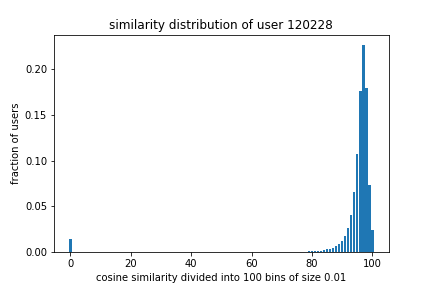

In [8]:
from IPython.display import Image
Image(filename='plots/120228.png')

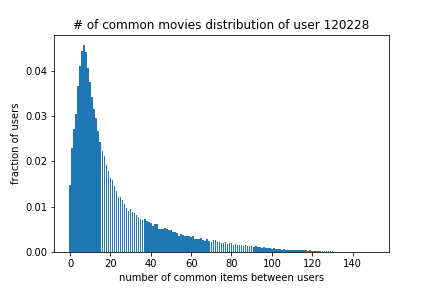

In [9]:
from IPython.display import Image
Image(filename='plots/120228_size.png')

We try different bands(b)(also known as the hash size) and rows(r)(also known as the number of hash tables) values and using the thershold t in (0.8,0.83,0.85,0.87,0.9), calculate the precision and recall values of the approximate nearest neighbors of a user from the r hash tables. (refer to complete_run.py).

b: (2,3,4,5,6,7,8,9,10)<br>
r: (4,6,8,10,12,14,16,18,20)<br>
threshold: (0.8,0.83,0.85,0.87,0.9)

the b-r table with recall/precision values for the threshold 0.87 is <br>
code for reading the results is in read_br_results.ipynb <br>

<table class="table table-bordered table-hover table-condensed">
<thead><tr><th title="Field #1">b-values\r-values</th>
<th title="Field #2">4</th>
<th title="Field #3">6</th>
<th title="Field #4">8</th>
<th title="Field #5">10</th>
<th title="Field #6">12</th>
<th title="Field #7">14</th>
<th title="Field #8">16</th>
<th title="Field #9">18</th>
<th title="Field #10">20</th>
</tr></thead>
<tbody><tr>
<td align="right">2</td>
<td>0.721/0.643</td>
<td>0.876/0.636</td>
<td>0.927/0.632</td>
<td>0.963/0.632</td>
<td>0.976/0.629</td>
<td>0.986/0.629</td>
<td>0.994/0.628</td>
<td>0.997/0.628</td>
<td>0.998/0.627</td>
</tr>
<tr>
<td align="right">3</td>
<td>0.442/0.645</td>
<td>0.611/0.658</td>
<td>0.702/0.643</td>
<td>0.776/0.643</td>
<td>0.827/0.636</td>
<td>0.876/0.635</td>
<td>0.917/0.637</td>
<td>0.941/0.634</td>
<td>0.954/0.633</td>
</tr>
<tr>
<td align="right">4</td>
<td>0.252/0.653</td>
<td>0.383/0.655</td>
<td>0.481/0.665</td>
<td>0.551/0.663</td>
<td>0.655/0.664</td>
<td>0.666/0.649</td>
<td>0.708/0.65</td>
<td>0.758/0.646</td>
<td>0.79/0.647</td>
</tr>
<tr>
<td align="right">5</td>
<td>0.149/0.669</td>
<td>0.221/0.679</td>
<td>0.267/0.651</td>
<td>0.347/0.695</td>
<td>0.367/0.659</td>
<td>0.44/0.674</td>
<td>0.477/0.667</td>
<td>0.485/0.652</td>
<td>0.541/0.658</td>
</tr>
<tr>
<td align="right">6</td>
<td>0.082/0.68</td>
<td>0.109/0.682</td>
<td>0.137/0.67</td>
<td>0.183/0.679</td>
<td>0.21/0.681</td>
<td>0.239/0.671</td>
<td>0.3/0.689</td>
<td>0.328/0.687</td>
<td>0.328/0.673</td>
</tr>
<tr>
<td align="right">7</td>
<td>0.043/0.709</td>
<td>0.063/0.691</td>
<td>0.082/0.686</td>
<td>0.112/0.706</td>
<td>0.136/0.699</td>
<td>0.15/0.701</td>
<td>0.163/0.697</td>
<td>0.197/0.71</td>
<td>0.202/0.697</td>
</tr>
<tr>
<td align="right">8</td>
<td>0.021/0.695</td>
<td>0.037/0.712</td>
<td>0.052/0.727</td>
<td>0.049/0.689</td>
<td>0.069/0.708</td>
<td>0.078/0.702</td>
<td>0.088/0.704</td>
<td>0.102/0.711</td>
<td>0.114/0.71</td>
</tr>
<tr>
<td align="right">9</td>
<td>0.014/0.752</td>
<td>0.017/0.687</td>
<td>0.024/0.735</td>
<td>0.035/0.742</td>
<td>0.031/0.689</td>
<td>0.04/0.696</td>
<td>0.05/0.717</td>
<td>0.054/0.709</td>
<td>0.06/0.712</td>
</tr>
<tr>
<td align="right">10</td>
<td>0.006/0.755</td>
<td>0.008/0.715</td>
<td>0.013/0.753</td>
<td>0.017/0.73</td>
<td>0.018/0.723</td>
<td>0.024/0.748</td>
<td>0.024/0.716</td>
<td>0.029/0.734</td>
<td>0.034/0.731</td>
</tr>
</tbody></table>


We focus more on precision keeping a decent recall, because the purpose of our model is to obtain some nearest neighbors so as to reduce the model complexity. If try to obtain all the nearest neigbors by increasing the r value or by decreasing the b value the number of nearest neighbors will be close to the total number of users and that defeatst the purpose os using approximate nearest neighbors to reduce the similar users set size.<br>

For the above reason we choose b = 7 and r = 10 for all the calculations ahead.

### Sim-Hash Results: <br>

Now we use the first 4 splits of the data to perform 4 fold cross validation of the the KnnBasic model using the cosine similarity as the similarity metric for the approximate nearest neigbors (refer to code : cross_validate.py). We vary the number of nearest neigbors in knn from 10-150 in intervals of 10 and calcualate the rmse and mae (refer to code: rmse.ipynb)<br>

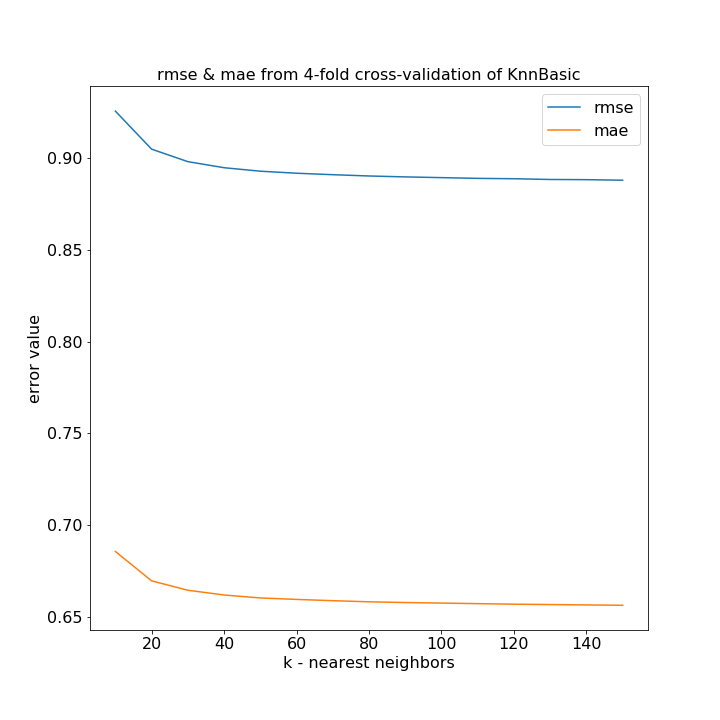

In [10]:
from IPython.display import Image
Image(filename='plots/rmse_mae.png')

We observed that rmse and mae follow the same trend and show very small improvement from k=100 to k=150. So for the final evalution of the model on the final test data we choose k=100 as the number of nearest neighbors. We finally evaulate the model on a set of 6770 users(refer to final_run.py).<br>

We also evaluated the Knn baseline model using the same parameters as mentions (b=7,r=10 and k = 100) on the final train and final test sets.(refer to final_run_baseline.py)<br>

We compared our knn cosine model with approximate nearest neigbors with the baseline approach and the knn baseline model with approximater nearest neighbors, output the comparision to a plot(refer to rmse.ipynb)

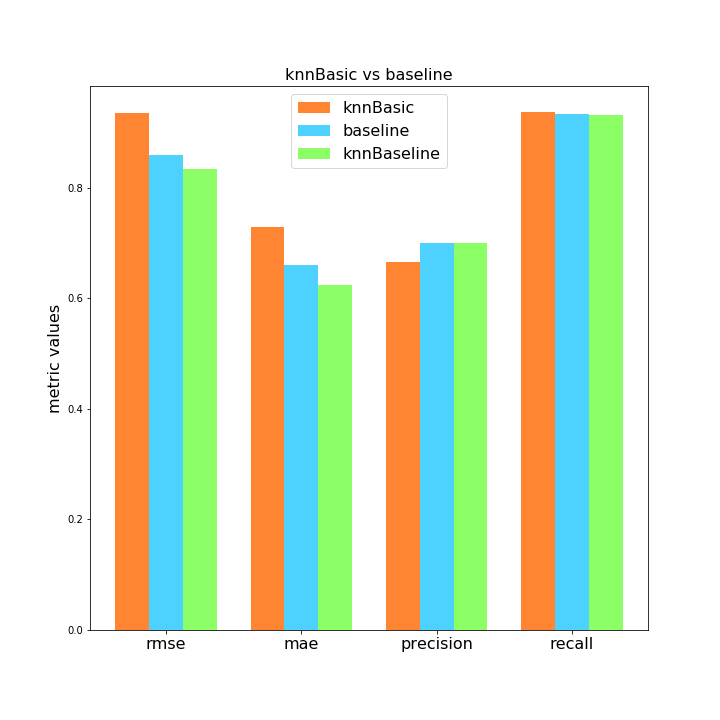

In [11]:
from IPython.display import Image
Image(filename='plots/final_plot1.png')

From the plot it is clear that our knn basic model (with cosine similarity) did not outperform the baseline approch in any of the chosen metrics. However, we have implemented a faster approach to the knnBasic model from the project_part1 and our results are comparable to the project_part1 as shown in the figure below. <br>

We can also see that the knnBaseline model defined in project_part1 and above out performs the baseline approach in terms of rmse and mae, but more importantaly it doesnot perform worse in any of the choosen metrics. From project_part1 we observed that the knnbaseline approach perform better than the other knn models and we saw similar results from the above plot. We overcame the complexity of the knn models by using approximate nearest neigbors. We can further continue the research and implement the item based knn models and observe the results and see if they outperform the user based models.

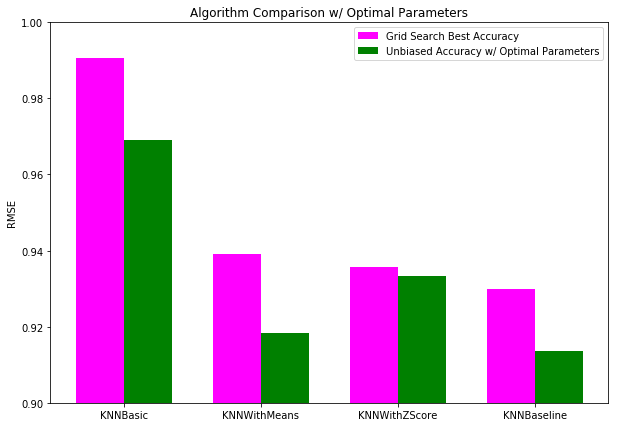

In [12]:
from IPython.display import Image
Image(filename='plots/part1.png')

# Conclusion
------------
1) Reduced the model complexity of the knn models by considering the approximate nearest neighbors. <br>
2) Efficient spark implimentation for moderately big data, which can be improved using big tables and precomputations for big data. <br>
3) Easy to generate a candidate set for the user using approximate nearest neighbors. <br>


# Future Considerations
-----------------------
1) Explore other features to incorporate in user/item vectors. This may include other IMDB features such as producer, writer, and year of release, or perhaps something more complex such as tf-idf for critic reviews. <br>
2) Combine both LSH and content-based approaches into a single ensemble system and find optimal weights for each model. <br>
3) Use maching learning techniques to learn the features that are important for each user and thus, each user will have personalized weights for each feature category. <br>
4) Find the optimal number of content-based recommendations and LSH recommendations for mixed recommender system. <br>
5) Explore the item based knn models with pearson similarity and pearson with baseline similarity.